In [69]:
import numpy as np
import pandas as pd
import sqlite3
import sys
import os
import re
from urllib.parse import urlparse
from scipy import stats
import matplotlib.pyplot as plt
data_path = 'exp-data/'

In [2]:
def get_content_type_from_headers(x):
    ls = x.replace('"','').split('],[')
    for l in ls:
        ta = l.replace(']]','').split(',')
        if "content-type" in ta:
            return ta[-1]
    return ''
def get_content_length_from_headers(x):
    ls = x.replace('"','').split('],[')
    for l in ls:
        ta = l.replace(']]','').split(',')
        if "content-length" in ta:
            return int(ta[-1])
    return 0
def extract_host_from_url(url_ls):
    return list(map(lambda x: urlparse(x).netloc.split('.')[1] if len(urlparse(x).netloc.split('.')) > 1 else urlparse(x).netloc, url_ls))
def is_third_party(origin, url_host):
    if origin in url_host:
        return False
    return True
def extract_deep_clean_host(url):
    s = url.strip(".au").strip('.uk')
    return s.split('.')[-2] if len(s.split('.')) > 1 else s
def save_df_to_csv(df, file_name):
    df.to_csv(file_name+'.csv', index=False)

In [5]:
def extract_tracker_table(type_name, exp_type, num):
    query = """SELECT sv.site_url, sv.visit_id,
        hr.url, hr.headers
        FROM http_responses as hr LEFT JOIN site_visits as sv
        ON sv.visit_id = hr.visit_id
        """
    sql_file = data_path + type_name + "-" + exp_type + str(num) + '.sqlite'
    print(sql_file)
    conn = sqlite3.connect(sql_file)
    http_responses = pd.read_sql_query(query, conn)

    http_responses['origin_site'] = extract_host_from_url(http_responses.site_url)
    http_responses["url_host"] = list(map(lambda x:urlparse(x).netloc, http_responses.url))
    http_responses["content_type"] = list(map(lambda x:get_content_type_from_headers(x), http_responses.headers))
    http_responses["content_length"] = list(map(lambda x:get_content_length_from_headers(x), http_responses.headers))
    http_responses["url_host_name"] = list(map(lambda x:extract_deep_clean_host(x), http_responses.url_host))

    http_responses['is_third_party'] = list(map(lambda a, b: is_third_party(a, b), http_responses.origin_site, http_responses.url_host))

    http_responses_images = http_responses[http_responses.content_type.str.contains('image')]
    http_responses_images_trackers = http_responses_images[http_responses_images.content_length < 100000]

    http_responses_images_trackers = http_responses_images_trackers[['origin_site', 'url_host', 'url_host_name','content_type', 'content_length', 'is_third_party']]

#     df = http_responses_images_trackers.groupby(['origin_site', 'url_host_name']).size().reset_index(name='count')
    http_responses_images_trackers['exp_group'] = [exp_type] * http_responses_images_trackers.shape[0]
    http_responses_images_trackers['exp_type'] = [type_name] * http_responses_images_trackers.shape[0]
    http_responses_images_trackers['exp_index'] = [str(num)] * http_responses_images_trackers.shape[0]
    return http_responses_images_trackers

In [28]:
def extract_images_from_httprequests(type_name, exp_type, num):
    query = """SELECT sv.site_url, sv.visit_id,
            hr.url, hr.headers, hr.resource_type
            FROM http_requests as hr LEFT JOIN site_visits as sv
            ON sv.visit_id = hr.visit_id
            """
    sql_file = data_path + type_name + "-" + exp_type + str(num) + '.sqlite'
    print(sql_file)
    conn = sqlite3.connect(sql_file) 
    http_requests = pd.read_sql_query(query, conn)

    http_requests_images = http_requests[http_requests.resource_type=='image']
    http_requests_images['origin_site'] = extract_host_from_url(http_requests_images.site_url)
    http_requests_images["url_host"] = list(map(lambda x:urlparse(x).netloc, http_requests_images.url))
    http_requests_images["url_host_name"] = list(map(lambda x:extract_deep_clean_host(x), http_requests_images.url_host))
    http_requests_images['is_third_party'] = list(map(lambda a, b: is_third_party(a, b), http_requests_images.origin_site, http_requests_images.url_host))
    http_requests_images = http_requests_images[http_requests_images.is_third_party]
    http_requests_images['exp_group'] = [exp_type] * http_requests_images.shape[0]
    http_requests_images['exp_type'] = [type_name] * http_requests_images.shape[0]
    http_requests_images['exp_index'] = [num] * http_requests_images.shape[0]
    return http_requests_images

In [6]:
types = ['nyt', 'forbes', 'washington']
exps = ['t', 'c']
df_ls = []
for i in range(1, 7):
    for t in types:
        for e in exps:
            df = extract_tracker_table(t, e, i)
            df_ls.append(df)
result = pd.concat(df_ls)

exp-data/nyt-t1.sqlite
exp-data/nyt-c1.sqlite
exp-data/forbes-t1.sqlite
exp-data/forbes-c1.sqlite
exp-data/washington-t1.sqlite
exp-data/washington-c1.sqlite
exp-data/nyt-t2.sqlite
exp-data/nyt-c2.sqlite
exp-data/forbes-t2.sqlite
exp-data/forbes-c2.sqlite
exp-data/washington-t2.sqlite
exp-data/washington-c2.sqlite
exp-data/nyt-t3.sqlite
exp-data/nyt-c3.sqlite
exp-data/forbes-t3.sqlite
exp-data/forbes-c3.sqlite
exp-data/washington-t3.sqlite
exp-data/washington-c3.sqlite
exp-data/nyt-t4.sqlite
exp-data/nyt-c4.sqlite
exp-data/forbes-t4.sqlite
exp-data/forbes-c4.sqlite
exp-data/washington-t4.sqlite
exp-data/washington-c4.sqlite
exp-data/nyt-t5.sqlite
exp-data/nyt-c5.sqlite
exp-data/forbes-t5.sqlite
exp-data/forbes-c5.sqlite
exp-data/washington-t5.sqlite
exp-data/washington-c5.sqlite
exp-data/nyt-t6.sqlite
exp-data/nyt-c6.sqlite
exp-data/forbes-t6.sqlite
exp-data/forbes-c6.sqlite
exp-data/washington-t6.sqlite
exp-data/washington-c6.sqlite


In [29]:
types = ['nyt', 'forbes', 'washington']
exps = ['t', 'c']
dfs = []
for i in range(1, 7):
    for t in types:
        for e in exps:
            df = extract_images_from_httprequests(t, e, i)
            dfs.append(df)

requests_result = pd.concat(dfs)

exp-data/nyt-t1.sqlite


/Users/rainyleon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/rainyleon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/rainyleon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

exp-data/nyt-c1.sqlite
exp-data/forbes-t1.sqlite
exp-data/forbes-c1.sqlite
exp-data/washington-t1.sqlite
exp-data/washington-c1.sqlite
exp-data/nyt-t2.sqlite
exp-data/nyt-c2.sqlite
exp-data/forbes-t2.sqlite
exp-data/forbes-c2.sqlite
exp-data/washington-t2.sqlite
exp-data/washington-c2.sqlite
exp-data/nyt-t3.sqlite
exp-data/nyt-c3.sqlite
exp-data/forbes-t3.sqlite
exp-data/forbes-c3.sqlite
exp-data/washington-t3.sqlite
exp-data/washington-c3.sqlite
exp-data/nyt-t4.sqlite
exp-data/nyt-c4.sqlite
exp-data/forbes-t4.sqlite
exp-data/forbes-c4.sqlite
exp-data/washington-t4.sqlite
exp-data/washington-c4.sqlite
exp-data/nyt-t5.sqlite
exp-data/nyt-c5.sqlite
exp-data/forbes-t5.sqlite
exp-data/forbes-c5.sqlite
exp-data/washington-t5.sqlite
exp-data/washington-c5.sqlite
exp-data/nyt-t6.sqlite
exp-data/nyt-c6.sqlite
exp-data/forbes-t6.sqlite
exp-data/forbes-c6.sqlite
exp-data/washington-t6.sqlite
exp-data/washington-c6.sqlite


In [248]:
requests_result.groupby(['origin_site', 'url_host_name', 'exp_group']).size().reset_index(name='count').sort_values(by=['exp_group',\
                                                                                                                       'origin_site',\
                                                                                                                       'count'],
                                                                                                                   ascending = False)

,origin_site,url_host_name,exp_group,count
568,webmd,doubleclick,t,1005
643,webmd,moatads,t,811
634,webmd,media,t,579
599,webmd,googlesyndication,t,577
597,webmd,google,t,287
625,webmd,liadm,t,258
688,webmd,rubiconproject,t,241
531,webmd,bidswitch,t,224
488,webmd,2mdn,t,220
552,webmd,criteo,t,199


In [136]:
summary = requests_result.groupby(['exp_group', 'exp_index', 'exp_type']).size().reset_index(name='counts')

summary

In [144]:
# T statistics
t_group = summary[(summary.exp_group == 't') & (summary.exp_type=='washington')].counts
c_group = summary[(summary.exp_group == 'c') & (summary.exp_type=='washington')].counts

In [147]:
stats.ttest_ind(t_group.tolist(), c_group.tolist())

Ttest_indResult(statistic=2.0842910012527027, pvalue=0.06373710474129275)

In [250]:
requests_result.groupby(['origin_site', 'exp_group']).size().reset_index(name='counts')

,origin_site,exp_group,counts
0,forbes,c,1374
1,forbes,t,1381
2,mayoclinic,c,2688
3,mayoclinic,t,8988
4,nytimes,c,716
5,nytimes,t,890
6,washingtonpost,c,401
7,washingtonpost,t,437
8,webmd,c,9439
9,webmd,t,7633


In [21]:
# save_df_to_csv(result, 'image_trackers_all')

In [103]:
trackers_t = result[result.exp_num.str.contains('t')].groupby(['exp_type', 'origin_site', 'url_host_name'])['count'].sum().reset_index(name='sum')

trackers_c = result[result.exp_num.str.contains('c')].groupby(['exp_type', 'origin_site', 'url_host_name'])['count'].sum().reset_index(name='sum')

combined_trackers = pd.merge(trackers_c, trackers_t, on=['exp_type','origin_site', 'url_host_name'], how='outer', suffixes=('_control', '_treatment'))

# trackers_t.join(trackers_c, on=['exp_type','origin_site', 'url_host_name'],  how='outer')

combined_trackers = combined_trackers.fillna(0)

combined_trackers[combined_trackers.sum_control < combined_trackers.sum_treatment].shape

combined_trackers[combined_trackers.sum_control > combined_trackers.sum_treatment].shape

combined_trackers[combined_trackers.sum_control == combined_trackers.sum_treatment].shape

# save_df_to_csv(combined_trackers, 'image_trakers_combined')

combined_trackers.groupby(['exp_type', 'origin_site'])[['sum_control', 'sum_treatment']].sum().stack().reset_index()

In [129]:
# save_df_to_csv(combined_trackers, 'image_trakers_combined')

In [138]:
combined_trackers.groupby(['exp_type', 'origin_site'])[['sum_control', 'sum_treatment']].sum().stack().reset_index()

,exp_type,origin_site,level_2,0
0,forbes,forbes,sum_control,438.0
1,forbes,forbes,sum_treatment,454.0
2,forbes,mayoclinic,sum_control,661.0
3,forbes,mayoclinic,sum_treatment,1099.0
4,forbes,webmd,sum_control,2035.0
5,forbes,webmd,sum_treatment,1793.0
6,nyt,mayoclinic,sum_control,640.0
7,nyt,mayoclinic,sum_treatment,1233.0
8,nyt,nytimes,sum_control,495.0
9,nyt,nytimes,sum_treatment,537.0


In [158]:
for_model = result.groupby(['exp_index', 'exp_group', 'exp_type', 'origin_site'])['count'].sum().reset_index(name='sum')

In [160]:
# save_df_to_csv(for_model, "pixel_tracker_for_model")

# result = pd.read_csv("image_trackers_all.csv")

In [204]:
t1 = response_result.groupby(['exp_group', 'origin_site']).size().reset_index(name='counts')

t1 = pd.merge(t1[t1.exp_group=='c'], t1[t1.exp_group=='t'], how='outer', on='origin_site', suffixes=['_control', '_treatment'])

t1

In [202]:
t4 = response_result[response_result.content_length < 100].groupby(['exp_group', 'origin_site']).size().reset_index(name='counts')
t4 = pd.merge(t4[t4.exp_group=='c'], t4[t4.exp_group=='t'], how='outer', on='origin_site', suffixes=['_control', '_treatment'])
t4

,exp_group_control,origin_site,counts_control,exp_group_treatment,counts_treatment
0,c,forbes,385,t,395
1,c,mayoclinic,1076,t,2972
2,c,nytimes,135,t,169
3,c,washingtonpost,119,t,123
4,c,webmd,4834,t,3326


In [201]:
t3 = response_result[response_result.content_length < 50].groupby(['exp_group', 'origin_site']).size().reset_index(name='counts')
t3 = pd.merge(t3[t3.exp_group=='c'], t3[t3.exp_group=='t'], how='outer', on='origin_site', suffixes=['_control', '_treatment'])
t3

,exp_group_control,origin_site,counts_control,exp_group_treatment,counts_treatment
0,c,forbes,379,t,389
1,c,mayoclinic,943,t,2844
2,c,nytimes,122,t,154
3,c,washingtonpost,119,t,123
4,c,webmd,4761,t,3293


In [197]:
t2 = response_result[response_result.content_length==0].groupby(['exp_group', 'origin_site']).size().reset_index(name='counts')
t2 = pd.merge(t2[t2.exp_group=='c'], t2[t2.exp_group=='t'], how='outer', on='origin_site', suffixes=['_control', '_treatment'])
t2

,exp_group_control,origin_site,counts_control,exp_group_treatment,counts_treatment
0,c,forbes,42,t,42
1,c,mayoclinic,135,t,1065
2,c,nytimes,17,t,24
3,c,washingtonpost,47,t,47
4,c,webmd,2184,t,1021


In [210]:
def ls_minus(ls1, ls2):
    result = []
    for x, y in zip(ls1, ls2):
        result.append(x - y)
    return result

In [212]:
x = ['100KB', '100B', '50B', '0']
nyt_c = [250, 135, 122, 17]
nyt_t = [296, 169, 154, 24]
forbes_c = [397, 385, 379, 42]
forbes_t = [411, 395, 389, 42]
washington_c = [135, 119, 119, 47]
washington_t = [143, 123, 123, 47]

/Users/rainyleon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


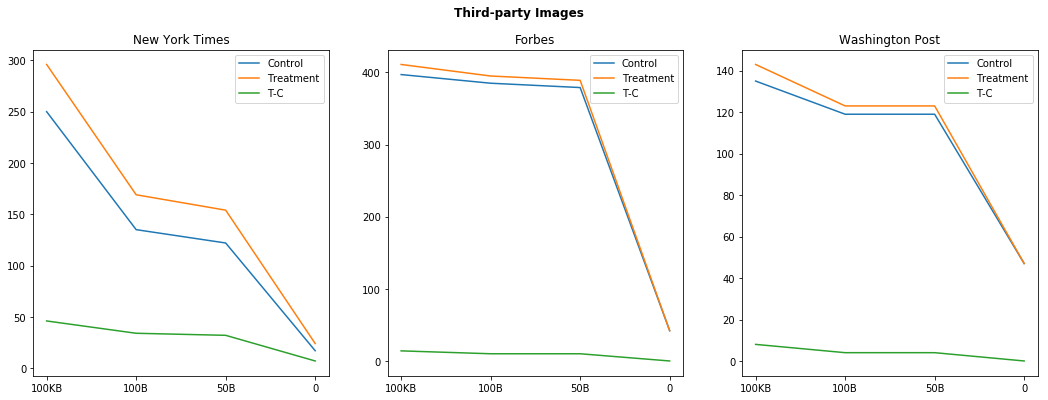

In [226]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))
fig.suptitle('Third-party Images', fontweight='bold')
axs[0].plot(x, nyt_c, label = "Control")
axs[0].plot(x, nyt_t, label = "Treatment")
axs[0].plot(x, ls_minus(nyt_t, nyt_c), label="T-C")
axs[0].legend()
axs[0].set_title('New York Times')
axs[1].plot(x, forbes_c, label = "Control")
axs[1].plot(x, forbes_t, label = "Treatment")
axs[1].plot(x, ls_minus(forbes_t, forbes_c), label="T-C")
axs[1].legend()
axs[1].set_title('Forbes')
axs[2].plot(x, washington_c, label = "Control")
axs[2].plot(x, washington_t, label = "Treatment")
axs[2].plot(x, ls_minus(washington_t, washington_c), label="T-C")
axs[2].legend()
axs[2].set_title('Washington Post')
fig.show()

In [152]:
response_result = pd.read_csv("image_trackers_all.csv")
response_result = response_result[response_result.is_third_party]

In [163]:
response_result

,origin_site,url_host,url_host_name,content_type,content_length,is_third_party,exp_group,exp_type,exp_index
21,webmd,px.moatads.com,moatads,image/gif,43,True,t,nyt,1
22,webmd,contextual.media.net,media,image/gif,43,True,t,nyt,1
23,webmd,px.moatads.com,moatads,image/gif,43,True,t,nyt,1
24,webmd,px.moatads.com,moatads,image/gif,43,True,t,nyt,1
25,webmd,cslogger.media.net,media,image/gif,35,True,t,nyt,1
28,webmd,ibclick.stream,ibclick,image/gif,37,True,t,nyt,1
29,webmd,contextual.media.net,media,image/gif,45,True,t,nyt,1
30,webmd,contextual.media.net,media,image/gif,45,True,t,nyt,1
31,webmd,contextual.media.net,media,image/gif,45,True,t,nyt,1
32,webmd,cs.media.net,media,image/gif,45,True,t,nyt,1


In [242]:
# pairwise
b = response_result.groupby(['exp_group', 'origin_site', 'exp_index']).size().reset_index(name='counts')
c_ls = b[(b.exp_group=='c') & (b.origin_site=='mayoclinic')].counts.tolist()
t_ls = b[(b.exp_group=='t') & (b.origin_site=='mayoclinic')].counts.tolist()

stats.ttest_ind(c_ls, t_ls)

In [247]:
response_result.groupby(['origin_site','exp_group']).size().reset_index()

,origin_site,exp_group,0
0,forbes,c,397
1,forbes,t,411
2,mayoclinic,c,1151
3,mayoclinic,t,3453
4,nytimes,c,250
5,nytimes,t,296
6,washingtonpost,c,135
7,washingtonpost,t,143
8,webmd,c,5424
9,webmd,t,3798


In [256]:
response_result[response_result.content_length==0].groupby(['origin_site', 'url_host_name', 'exp_group']).size()

origin_site     url_host_name      exp_group
forbes          adform             c               6
                                   t               6
                deepintent         t               1
                doubleclick        c              26
                                   t              26
                facebook           c               2
                                   t               3
                googlesyndication  c               8
                                   t               5
                gstatic            t               1
mayoclinic      adform             t               9
                adsrvr             t               1
                brightcove         c              12
                deepintent         c               2
                                   t               9
                doubleclick        c              88
                                   t             673
                facebook           t               3
 